In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../experiments")


from experiment_information import *
from experiment_setup import *
from data import *
from helpers import *
from data_loading import *
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np
import re
%load_ext autoreload
%autoreload 2



This code assumes that you have defined and run an experiment before using `define_experiment.ipynb` in the `experiments` folder.

In [2]:
df_experiments, df_state_evolution, df_erm = obtain_dataframes(logger)
df_experiments.head(5)

Current code version, 113


,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
55,e0455cbf-d8d4-4db5-a1ae-fd56eb40e292,DifferentSigmaW,23.567899,"[""Logistic""]",113,2024-07-01 17:07:22,1,0,"[0.001, 0.0015, 0.0021, 0.0031, 0.0044, 0.0064...","[0.0, 0.1, 0.2, 0.3, 0.4]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
54,97bab239-8528-47c0-ab8c-bcfccc890913,DifferentSigmaW,16.709738,"[""Logistic""]",113,2024-07-01 15:53:20,1,0,"[0.001, 0.0015, 0.0021, 0.0031, 0.0044, 0.0064...","[0.0, 0.1, 0.2, 0.3, 0.4]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
53,9c0b9876-2fef-46ff-81dd-d5b5518514c2,DifferentSigmaW,16.650080,"[""Logistic""]",113,2024-07-01 14:54:39,1,0,"[0.001, 0.0014, 0.0021, 0.003, 0.0043, 0.0061,...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
52,29363a8c-c89c-4eda-a059-b8ba743bcb53,DifferentSigmaW,10.998375,"[""Logistic""]",113,2024-07-01 11:22:04,1,0,"[0.001, 0.0014, 0.0021, 0.003, 0.0043, 0.0061,...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
50,c02b94b1-cac0-4ebe-9592-3487c3555d08,DifferentSigmaW,45.117960,"[""Logistic""]",113,2024-07-01 11:18:27,1,10,"[0.001, 0.0014, 0.0021, 0.003, 0.0043, 0.0061,...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [3]:
experiment_loc = 3

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

29363a8c-c89c-4eda-a059-b8ba743bcb53
Sweep
KFeaturesModel
KFeaturesModel
KFeaturesModel
['KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[1 1]___DifferentSigmaW', 'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[2 1]___DifferentSigmaW', 'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[1 2]___DifferentSigmaW']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Non Id, Sigma w Id", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Non Id, Sigma w Non Id", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Non Id, Sigma w Non Id"]
DifferentSigmaW
['Logistic']


In [4]:
# name for the plots ----
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1"] = "Robust Non-Useful"

data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[4 4]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1"] = "Robust Non-Useful"


data_model_name_dict['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1'] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1"] = "Non-Robust Useful"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"

# 'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1.  1.5]_SU_1_1_Sw_[1 1]',
#        'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1.  1.5]_SU_1_1_Sw_[1.5 1. ]',
#        'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1.  1.5]_SU_1_1_Sw_[1.  1.5]'

data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1.  1.5]_SU_1_1_Sw_[1 1]"] = "Uniform Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1.  1.5]_SU_1_1_Sw_[1.5 1. ]"] = "Opposite Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1.  1.5]_SU_1_1_Sw_[1.  1.5]"] = "Same Regularisation"

# KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 1]
#        'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[5 1]',
#        'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 5]'

data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 1]"] = "Uniform Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[5 1]"] = "Opposite Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 5]"] = "Same Regularisation"

data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[1 1]"] = "Uniform Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[2 1]"] = "Opposite Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[1 2]"] = "Same Regularisation"

# 'KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1___Defence Sweep'

In [5]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_42480/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_42480/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [6]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [7]:
# def compute_mu_usefulness(row):
#     rho = row["rho"]
#     tau = row["tau"]

#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * rho / np.sqrt( rho + tau**2 )

# def compute_gamma_robustness(row):
#     rho = row["rho"]
#     tau = row["tau"]


#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * tau / np.sqrt( rho + tau**2 )

# def compute_mu_usefulness_ratio(row):

In [8]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [9]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [10]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [11]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [12]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [13]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [14]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [15]:
def extract_theta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-1].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()
    

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_second # / theta_first  


state_evolution["theta_ratio"] = state_evolution["data_model_name"].apply(extract_theta_ratio)
gd["theta_ratio"] = gd["data_model_name"].apply(extract_theta_ratio)

In [16]:
def extract_sigmax_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-2].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_first # / theta_second


state_evolution["sigmax_ratio"] = state_evolution["data_model_name"].apply(extract_sigmax_ratio)
gd["sigmax_ratio"] = gd["data_model_name"].apply(extract_sigmax_ratio)

In [17]:
def extract_sigmadelta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_second  #/ theta_first

def extract_sigmadelta_scale(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_first


# state_evolution["sigmadelta_ratio"] = state_evolution["data_model_name"].apply(extract_sigmadelta_ratio)
# gd["sigmadelta_ratio"] = gd["data_model_name"].apply(extract_sigmadelta_ratio)

# state_evolution["sigmadelta_scale"] = state_evolution["data_model_name"].apply(extract_sigmadelta_scale)
# gd["sigmadelta_scale"] = gd["data_model_name"].apply(extract_sigmadelta_scale)

In [18]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","theta_ratio","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6,7,8]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6,7,8]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                                                  mean   
alpha epsilon tau  lam   problem_type attack_epsilon sigmax_ratio theta_ratio data_model_name                                                            
0.001 0.0     0.05 0.001 Logistic     0.1            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               65015.0   
                                                                              KFeaturesModel_TwoFeatures_NonuniformProtection...               65477.0   
                                                                  2.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               66008.0   
                                      0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               65016.0   
                                                                              KFeaturesModel_TwoFeatures_NonuniformProtection...               65478.0   
...                                                                                                                                                ...   
2.000 0.3     0.05 0.010 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               66036.0   
                                                                  2.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               66540.0   
                                      0.3            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               65500.0   
                                                                              KFeaturesModel_TwoFeatures_NonuniformProtection...               66037.0   
                                                                  2.0         KFeaturesModel_TwoFeatures_NonuniformProtection...               66541.0   

                                                                                                                                      \
                                                                                                                                 std   
alpha epsilon tau  lam   problem_type attack_epsilon sigmax_ratio theta_ratio data_model_name                                          
0.001 0.0     0.05 0.001 Logistic     0.1            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                              KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                  2.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                      0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                              KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
...                                                                                                                               ..   
2.000 0.3     0.05 0.010 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                  2.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                      0.3            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                              KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                  2.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   

                                                                   

In [19]:
# def extract_rho_norm_usefulness(row):
#     # extract sigmax_ratio from the index
#     sigmax_ratio = row["sigmax_ratio"]
#     sigmatheta_ratio = row["theta_ratio"]

#     sigmax_ratio = float(sigmax_ratio)
#     sigmatheta_ratio = float(sigmatheta_ratio)

#     norm = (sigmax_ratio + sigmatheta_ratio**2) * 0.5

#     subspace_rho_1 = sigmax_ratio / (2 * norm)

#     usefulness = subspace_rho_1 / ( 1 - subspace_rho_1 )

#     subspace_rho_2 = sigmatheta_ratio**2 / (2*norm)

#     assert subspace_rho_1 + subspace_rho_2 - 1 < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_rho_1, subspace_rho_2)


#     return usefulness

# def extract_trace_norm_usefulness(row):
#     sigmax_ratio = row["sigmax_ratio"]
#     sigmatheta_ratio = row["theta_ratio"]
#     rho = row["rho_state_evolution"]["mean"]

#     sigmax_ratio = float(sigmax_ratio)
#     sigmatheta_ratio = float(sigmatheta_ratio)
#     rho = float(rho)

#     norm = (1/4) * (1 + sigmax_ratio) * ( 1 + sigmatheta_ratio**2)

#     subspace_1 = 0.5 * sigmax_ratio / norm
#     subspace_2 = 0.5 * sigmatheta_ratio**2 / norm

#     # assert subspace_1 + subspace_2 - rho < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_1, subspace_2)

#     usefulness = subspace_1 / ( rho - subspace_1 )

#     return usefulness

# def extract_relative_usefulness(row):
#     sigmax_ratio = row["sigmax_ratio"]
#     sigmatheta_ratio = row["theta_ratio"]

#     sigmax_ratio = float(sigmax_ratio)
#     sigmatheta_ratio = float(sigmatheta_ratio)

#     return sigmax_ratio / sigmatheta_ratio**2

# def extract_usefulness(row):
#     rho = row["rho_state_evolution"]["mean"]
#     rho = float(rho)
#     return rho


# df2 = df.reset_index()


# df2["total_usefulness"] = df2.apply(extract_usefulness, axis=1)

# # # apply mean and std to the new column
# # df_result = df2["total_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['total_usefulness'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # # Concatenate the original DataFrame with the computed values DataFrame
# # df2 = pd.concat([df2, df_result], axis=1)


# df2["rho_usefulness"] = df2.apply(extract_rho_norm_usefulness, axis=1)


# # apply mean and std to the new column
# df_result = df2["rho_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['rho_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["trace_usefulness"] = df2.apply(extract_trace_norm_usefulness, axis=1)

# # apply mean and std to the new column
# df_result = df2["trace_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['trace_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["relative_usefulness"] = df2.apply(extract_relative_usefulness, axis=1)

# # apply mean and std to the new column
# # df_result = df2["relative_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['relative_usefulness'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# # # apply mean and std to the column "theta_ratio"
# # df_result = df2["theta_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['theta_ratio'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # # Concatenate the original DataFrame with the computed values DataFrame
# # df2 = pd.concat([df2, df_result], axis=1)

# # df_result = df2["sigmax_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['sigmax_ratio'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # # Concatenate the original DataFrame with the computed values DataFrame
# # df2 = pd.concat([df2, df_result], axis=1)


# # set all quantities from the df index in df2 as index
# # df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","relative_usefulness","data_model_name"]) #,"p_calibration"
# # df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) 
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"


# # sort index
# df.sort_index()



In [20]:
df.index.get_level_values("data_model_name").unique()

Index(['KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[1 1]',
       'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[2 1]',
       'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 2]_SU_1_1_Sw_[1 2]'],
      dtype='object', name='data_model_name')

In [21]:
# # try replacing data_model_name in df with data_model_name_dict
df = df.reset_index()
df["data_model_name"] = df["data_model_name"].apply(lambda x: data_model_name_dict[x])
df = df.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","data_model_name"]) #,"p_calibration"
df.sort_index()

index_state_evolution  \
                                                                                                                       mean   
alpha epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio data_model_name                                 
0.001 0.0     0.05 0.001 Logistic     0.1            1.0         1.0          Opposite Regularisation               65477.0   
                                                                              Uniform Regularisation                65015.0   
                                                     2.0         1.0          Same Regularisation                   66008.0   
                                      0.2            1.0         1.0          Opposite Regularisation               65478.0   
                                                                              Uniform Regularisation                65016.0   
...                                                                                                                     ...   
2.000 0.3     0.05 0.010 Logistic     0.2            1.0         1.0          Uniform Regularisation                65499.0   
                                                     2.0         1.0          Same Regularisation                   66540.0   
                                      0.3            1.0         1.0          Opposite Regularisation               66037.0   
                                                                              Uniform Regularisation                65500.0   
                                                     2.0         1.0          Same Regularisation                   66541.0   

                                                                                                           \
                                                                                                      std   
alpha epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio data_model_name               
0.001 0.0     0.05 0.001 Logistic     0.1            1.0         1.0          Opposite Regularisation NaN   
                                                                              Uniform Regularisation  NaN   
                                                     2.0         1.0          Same Regularisation     NaN   
                                      0.2            1.0         1.0          Opposite Regularisation NaN   
                                                                              Uniform Regularisation  NaN   
...                                                                                                    ..   
2.000 0.3     0.05 0.010 Logistic     0.2            1.0         1.0          Uniform Regularisation  NaN   
                                                     2.0         1.0          Same Regularisation     NaN   
                                      0.3            1.0         1.0          Opposite Regularisation NaN   
                                                                              Uniform Regularisation  NaN   
                                                     2.0         1.0          Same Regularisation     NaN   

                                                                                                      duration_state_evolution  \
                                                                                                                          mean   
alpha epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio data_model_name                                    
0.001 0.0     0.05 0.001 Logistic     0.1            1.0         1.0          Opposite Regularisation                 0.045371   
                                                                              Uniform Regularisation                  0.939471   
                                                     2.0         1.0          Same Regularisation                     0.045563   
                

In [22]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [23]:
# extract unique data_model_name from index
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['Uniform Regularisation', 'Opposite Regularisation',
       'Same Regularisation'],
      dtype='object', name='data_model_name')

In [24]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/defence_sweep.pkl"):
    df.to_pickle("Pickles/defence_sweep.pkl")

In [25]:
# load the pickle
# df = pd.read_pickle("Pickles/defence_sweep.pkl")

# Extracting Data

In [26]:
df

index_state_evolution  \
                                                                                                                       mean   
alpha epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio data_model_name                                 
0.001 0.0     0.05 0.001 Logistic     0.1            1.0         1.0          Uniform Regularisation                65015.0   
                                                                              Opposite Regularisation               65477.0   
                                                     2.0         1.0          Same Regularisation                   66008.0   
                                      0.2            1.0         1.0          Uniform Regularisation                65016.0   
                                                                              Opposite Regularisation               65478.0   
...                                                                                                                     ...   
2.000 0.3     0.05 0.010 Logistic     0.2            1.0         1.0          Opposite Regularisation               66036.0   
                                                     2.0         1.0          Same Regularisation                   66540.0   
                                      0.3            1.0         1.0          Uniform Regularisation                65500.0   
                                                                              Opposite Regularisation               66037.0   
                                                     2.0         1.0          Same Regularisation                   66541.0   

                                                                                                           \
                                                                                                      std   
alpha epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio data_model_name               
0.001 0.0     0.05 0.001 Logistic     0.1            1.0         1.0          Uniform Regularisation  NaN   
                                                                              Opposite Regularisation NaN   
                                                     2.0         1.0          Same Regularisation     NaN   
                                      0.2            1.0         1.0          Uniform Regularisation  NaN   
                                                                              Opposite Regularisation NaN   
...                                                                                                    ..   
2.000 0.3     0.05 0.010 Logistic     0.2            1.0         1.0          Opposite Regularisation NaN   
                                                     2.0         1.0          Same Regularisation     NaN   
                                      0.3            1.0         1.0          Uniform Regularisation  NaN   
                                                                              Opposite Regularisation NaN   
                                                     2.0         1.0          Same Regularisation     NaN   

                                                                                                      duration_state_evolution  \
                                                                                                                          mean   
alpha epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio data_model_name                                    
0.001 0.0     0.05 0.001 Logistic     0.1            1.0         1.0          Uniform Regularisation                  0.939471   
                                                                              Opposite Regularisation                 0.045371   
                                                     2.0         1.0          Same Regularisation                     0.045563   
                

In [27]:
# extract unique epsilons
epsilons = df.index.get_level_values("epsilon").unique()
epsilons

alphas = df.index.get_level_values("alpha").unique()
alphas

Index([ 0.001, 0.0014, 0.0021,  0.003, 0.0043, 0.0061, 0.0088, 0.0126, 0.0181,
        0.026, 0.0373, 0.0536,  0.077, 0.1105, 0.1587,  0.228, 0.3274, 0.4702,
       0.6752, 0.9697, 1.3926,    2.0],
      dtype='float64', name='alpha')

In [28]:
reg_params = df.index.get_level_values("lam").unique()
reg_params

Index([0.001, 0.01], dtype='float64', name='lam')

In [29]:
defence_eps = df.index.get_level_values("epsilon").unique()
attack_eps = df.index.get_level_values("attack_epsilon").unique()

common_eps = list(set(defence_eps).intersection(attack_eps))
common_eps

[0.1, 0.3, 0.2]

In [30]:
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['Uniform Regularisation', 'Opposite Regularisation',
       'Same Regularisation'],
      dtype='object', name='data_model_name')

In [31]:
df.columns

MultiIndex([(                         'index_state_evolution', 'mean'),
            (                         'index_state_evolution',  'std'),
            (                      'duration_state_evolution', 'mean'),
            (                      'duration_state_evolution',  'std'),
            (          'generalization_error_state_evolution', 'mean'),
            (          'generalization_error_state_evolution',  'std'),
            (                 'training_loss_state_evolution', 'mean'),
            (                 'training_loss_state_evolution',  'std'),
            (                'training_error_state_evolution', 'mean'),
            (                'training_error_state_evolution',  'std'),
            ...
            (        'noiseless_generalization_error_erm_erm', 'mean'),
            (        'noiseless_generalization_error_erm_erm',  'std'),
            ('noiseless_adversarial_generalization_error_erm', 'mean'),
            ('noiseless_adversarial_generalizati

In [32]:
df_dict = {}

for data_model_name in data_model_names:

    df_data_model = df.xs(data_model_name, level="data_model_name")

    eps_dict = {}

    for e in common_eps:
        
        eps_df = df_data_model.xs((e, e, 0.001), level=["epsilon", "attack_epsilon", "lam"])

        alphas = eps_df.index.get_level_values("alpha").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        # class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values
        training_error_0 = eps_df["training_error_state_evolution"]["mean"].values

        alphas = np.array(alphas)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)

        eps_0_dict = {}
        eps_0_dict["alphas"] = alphas
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["training_error"] = training_error_0

        eps_dict[e] = eps_0_dict


    df_dict[data_model_name] = eps_dict

In [33]:
len(df_dict['Uniform Regularisation'][0.1]["adversarial_error"])

22

# Plotting

In [34]:

IMG_DIRECTORY = "./Assets/different_w"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


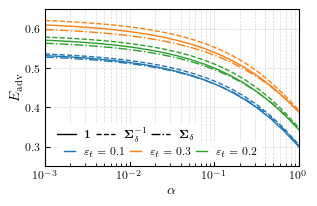

In [35]:
# width = 2.5 * 458.63788

width = 458.63788

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=0.5, subplots=(1, 1))
# tuple_size = (3 * 8.5 / 4, 2.4)

multiplier = 1.25
second_multiplier = 0.6

# import Line2D for custom legend
from matplotlib.lines import Line2D

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0, "wspace": 0},
)

fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# Create a custom legend
custom_legend = []
linestyles = ["solid", "dashed", "dashdot", "dotted"]

for df_idx, (key, value) in enumerate(df_dict.items()):

    data_model_name = key

    for idx, (epsilon, eps_dict) in enumerate(value.items()):
        if epsilon == 0.4:
            continue

        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        tra = eps_dict["training_error"]

        adversarial_lines = ax.plot(
            alphas, adversarial_error, linestyle=linestyles[df_idx], color=f"C{idx}"
        )

ax.set_xscale("log")
ax.set_ylabel(r"$E_{\mathrm{adv}}$", labelpad=2.0)
ax.set_xlabel(r"$\alpha$", labelpad=2.0)
ax.set_xlim([0.001, 1])
ax.set_ylim([0.25, 0.65])
ax.grid(which="both", axis="both", alpha=0.5)
ax.tick_params(axis="both", which="major", direction="in")
ax.tick_params(axis="both", which="minor", direction="in")


data_model_legend = []

data_model_legend_dict = {
    "Uniform Regularisation": r"$\boldsymbol{1}$",
    "Opposite Regularisation": r"$\boldsymbol{\Sigma}_{\delta}^{-1}$",
    "Same Regularisation": r"$\boldsymbol{\Sigma}_{\delta}$",
    # "Uniform Regularisation": r"$\boldsymbol{\Sigma}_{w} = \boldsymbol{1}$",
    # "Opposite Regularisation": r"$\boldsymbol{\Sigma}_{w} = \boldsymbol{\Sigma}_{\delta}^{-1}$",
    # "Same Regularisation": r"$\boldsymbol{\Sigma}_{w} = \boldsymbol{\Sigma}_{\delta}$",
}

for idx, (key, value) in enumerate(df_dict.items()):
    data_model_legend.append(
        Line2D(
            [0],
            [0],
            color="black",
            linestyle=linestyles[idx],
            label=data_model_legend_dict[key],
        )
    )

fig.legend(
    handles=data_model_legend,
    handlelength=1.7,
    bbox_to_anchor=(0.65,0.4),
    ncol=3,
    columnspacing=0.4
)


epsilon_legend = []

for idx, epsilon in enumerate(common_eps):
    if epsilon == 0.4:
        continue
    epsilon_legend.append(
        Line2D(
            [0],
            [0],
            color=f"C{idx}",
            linestyle="solid",
            label=r"$\varepsilon_t={}$".format(epsilon),
        )
    )

fig.legend(
    handles=epsilon_legend,
    handlelength=1,
    bbox_to_anchor=(0.85,0.3),
    ncol=3,
    columnspacing=0.5
)

save = True
if save:
    save_plot(
        fig,
        f"different_sigma_w_sweep",
    )

plt.show()

In [36]:
import pickle

# Save data_to_save using pickle
with open('data_eps_0.15.pickle', 'wb') as f:
    pickle.dump(data_to_save, f)


NameError: name 'data_to_save' is not defined

In [ ]:
for df_idx, (key, value) in enumerate(df_dict.items()):

    data_model_name = key

    for idx, (epsilon, eps_dict) in enumerate(value.items()):


        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]
        tra = eps_dict["training_error"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]

        plt.plot(
            alphas, adversarial_error, label=df_idx, linestyle=linestyles[idx]
        )

plt.xlabel(r"$\alpha$")
plt.xscale("log")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( tuple_size[0], 0.1 * tuple_size[0]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=4,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()



In [ ]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 0.1*tuple_size[0], 0.5*tuple_size[1]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

# display figure size
print("Figure size in inches: ", figlegend.get_size_inches())

error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 


# merge the two legends by concatenating the lists
custom_legend = error_legend + epsilon_legend


figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=1,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "vertical_legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()

